# MIRA Lab 1
*Robert Martí and Sandra González-Villà*


---


## Intensity-based image registration
In this notebook you have the code of a fully working registration framework, implementing a rigid registration algorithm which minimizes the sum of squared distances (SSD). Read and understand the following functions and answer the questions asked through the notebook. Then, complete the assigned tasks.

Lab Members:
1. Abdelrahman Usama Gabr Abdou Habib
2. Berta Calm Salvans

In [47]:
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import datetime

import cv2
from scipy.stats import entropy


In [2]:
def affine_transform_2d_double(Iin, M, order=3, mode=2, ImageSize=None):
    # Discussion Note:
    # From the package docx, the order of the spline interpolation, default is 3.
    # The order has to be in the range 0-5.

    boundaries = ['reflect', 'grid-mirror', 'constant', 'grid-constant',
                  'nearest', 'mirror', 'grid-wrap', 'wrap']

    if ImageSize is None:
        ImageSize = [Iin.shape[0], Iin.shape[1]]

    if order not in np.arange(6):
        raise ValueError('Invalid order value')

    if mode not in np.arange(8):
        raise ValueError('Invalid mode value')

    boundary = boundaries[mode] # default = constant

    x, y = np.meshgrid(np.arange(ImageSize[1]), np.arange(ImageSize[0]))

    mean_out = np.array(ImageSize) / 2
    mean_in = np.array(Iin.shape[:2]) / 2

    xd = x - mean_out[1]
    yd = y - mean_out[0]

    Tlocalx = mean_in[1] + M[0, 0] * xd + M[0, 1] * yd + M[0, 2] * 1
    Tlocaly = mean_in[0] + M[1, 0] * xd + M[1, 1] * yd + M[1, 2] * 1

    Iout = map_coordinates(Iin, [Tlocaly, Tlocalx], order=order, mode=boundary)

    return Iout

In [3]:
# NCC implementation
def ncc(img1, img2, negative=True):
    '''Normalized cross-correlation implementation.
    '''
    # calculate the means of each image
    img1_mean = np.mean(img1)
    img2_mean = np.mean(img2)

    # calculate the numerator
    num = np.sum((img1 - img1_mean) * (img2 - img2_mean))

    # calculate the denominator
    p1 = np.sqrt(np.sum((img1 - img1_mean)**2))
    p2 = np.sqrt(np.sum((img2 - img2_mean)**2))
    denum = p1 * p2
    
    result = num / denum

    return 1 - result if negative else result # we substract by 1 as we use a minimizing optimizer

# Gradient implementation function for NGC calculation
def grad(img, ksize=3):
    '''Computes the gradient (partial derivative) of image intensities.
    '''
    # calculate the gradient using 1st order sobel operator
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize)

    return grad_x, grad_y


# NGC implementation
def ngc(img1, img2, ksize=3, negative=True):
    '''Normalized gradient correlation implementation.
    '''
    # Calculate the input image gradients
    img1_grad_x, img1_grad_y = grad(img1, ksize)
    img2_grad_x, img2_grad_y = grad(img2, ksize)

    # calculate the numerator
    # num = np.sum(img1_grad_x * img2_grad_x + img1_grad_y * img2_grad_y)
    num = np.sum(np.abs((img1_grad_x * img2_grad_x) + (img1_grad_y * img2_grad_y)))

    # calculate the denominator
    p1 = np.sum(img1_grad_x**2 + img1_grad_y**2)
    p2 = np.sum(img2_grad_x**2 + img2_grad_y**2)

    # Handle potential division by zero
    denominator = np.sqrt(p1 * p2)
    # denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero

    result = num / denominator 

    return 1 - result if negative else result # we substract by 1 as we use a minimizing optimizer

In [4]:
# Helper function to generate a transformation matrix
def generate_transformation_matrix(x, ttype):

    if ttype == 'r': # rigid transformation
        # Discussion Notes:
        # Translation: x[0], x[1]
        # Rotation: x[2]
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
                
        #     # Discussion notes:
        #     # x stores the parameters, as we perform translation in x,y and rotation, x should be size of 1x3
        #     # the 3rd row of matrix M is to make the matrix multiplication possible and making the matrix homogeneous  
        
    elif ttype == 'a':
        # affine tranformation has 7 parameters, which are ax, bx, ay, by, tx, ty
        # we can build the matrix using matrix multiplication
        
        # references: 
        # 1. slide p(5): http://alumni.media.mit.edu/~maov/classes/comp_photo_vision08f/lect/08_image_warps.pdf
        # 2. https://www.mathworks.com/discovery/affine-transformation.html
        # 3. http://www.sci.utah.edu/~acoste/uou/Image/project3/ArthurCOSTE_Project3.pdf 

        # translation matrix
        T = np.array([[1, 0, x[0]], # x[0] => parameter 1 = tx
                      [0, 1, x[1]], # x[1] => parameter 2 = ty
                      [0, 0,   1 ]])
        
        # rotation matrix
        R = np.array([[np.cos(x[2]),  np.sin(x[2]),  0], # x[2] => parameter 3 => theta
                      [-np.sin(x[2]), np.cos(x[2]),  0],
                      [0,             0,             1]])
        
        # scaling matrix
        S =  np.array([[x[3],  0,    0], # x[3] => parameter 4 = sx
                       [0,     x[4], 0], # x[4] => parameter 5 = sy
                       [0,     0,    1]])
        
        # shear matrix
        SH = np.array([[1,     x[5], 0], # x[3] => parameter 6 = shx (TODO ASK: should be shy and below is shx?)
                       [x[6],  1,    0], # x[4] => parameter 7 = shy
                       [0,     0,    1]])
        
        # # Obtain the final matrix using matrix multiplication
        M = T @ R @ S @ SH

    else:
        raise ValueError('Unknown registration type')
    
    return M


def affine_registration_function(par, scale, Imoving, Ifixed, mtype, ttype, order):

    x = par * scale

    # This function will be called to generate the transformation matrix based on the transformation type
    # will be called in different places
    M = generate_transformation_matrix(x, ttype)

    I3 = affine_transform_2d_double(Imoving, M, order)

    if mtype == 'sd':  # squared differences
        # I3.size normalization term to calculate the mean squared difference
        e = np.sum((I3 - Ifixed)**2) / I3.size

    elif mtype == 'ncc':
        e  = ncc(I3, Ifixed, negative=True) 
    
    elif mtype == 'ngc':
        e  = ngc(I3, Ifixed, negative=True)

    else:
        raise ValueError('Unknown metric type')
    
    return e

In [5]:
# Implementation for multi-resolution function that retuns a pyramid of images, both fixed and moving into 2 separate lists, and
# a scaling factor
def create_multi_resolution_pyramid(Imoving, Ifixed, depth = 1, sigma = 1.5, scale_factor = 2, debug=False):
    '''This function create a multi-resolution pyramid of images with a given depth as a parameter. \
        It returns both moving and fixed images in a list starting from the lowest to highest resultion if \
        the depth > 1. If the depth is 1, it returns the original images. '''
    
    # https://www.researchgate.net/figure/Multi-resolution-pyramid-model-for-image-registration_fig2_350312761
    # P(7), uses gaussian filter: https://www.sciencedirect.com/science/article/pii/S0898122113002538  
    # check the slides of iterative pyramidal lucas-kanade pyramid design (gaussian filtering + downsampling by 2) to get lower scale/res images

    if depth == 0:
        raise ValueError("Depth can't be equal to 0, minimum allowed value is 1 for a single resolution image registration.")
    
    Imoving_list = []
    Ifixed_list  = []

    Imoving_list.append(Imoving)
    Ifixed_list.append(Ifixed)

    if depth == 1:
        return Imoving_list, Ifixed_list, scale_factor
    
    for _ in range(1, depth): # ignore the last level of the pyramid (depth+1), it is the original image
        # Apply Gaussian filtering
        # The lists have the original images, thus we index the last element at the beginning
        # when a new image is appended, that new image is used on the next level for filtering and downsampling
        Imoving_filtered = cv2.GaussianBlur(Imoving_list[-1], (0, 0), sigma)
        Ifixed_filtered = cv2.GaussianBlur(Ifixed_list[-1], (0, 0), sigma)

        # Apply downsampling by a factor of 2 for the first time on the original image, 
        Imoving_downsampled = cv2.resize(Imoving_filtered, None, fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR)
        Ifixed_downsampled = cv2.resize(Ifixed_filtered, None, fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR)

        # Appending to the list
        Imoving_list.append(Imoving_downsampled)
        Ifixed_list.append(Ifixed_downsampled)

    # The pyramid should start from the smallest image with the lowest resolution to the highest, reverse the lists
    Imoving_list.reverse()
    Ifixed_list.reverse()

    if debug:
        # Show the registration results
        plt.figure(figsize=(10, 8))
        
        view_depth_index = 3  # Only for visual debugging, no visual debugging if depth is 1 (1 level), the index must be equal to 0
        
        plt.subplot(1, 2, 1)
        plt.imshow(Ifixed_list[view_depth_index], cmap='gray')
        plt.title(f'Fixed Image {Ifixed_list[view_depth_index].shape}')

        plt.subplot(1, 2, 2)
        plt.imshow(Imoving_list[view_depth_index], cmap='gray')
        plt.title(f'Moving Image {Imoving_list[view_depth_index].shape}')

    # Return both pyramids of images , and the scale factor that we will use to scale the optimized parameters when moving between scales
    return Imoving_list, Ifixed_list, scale_factor


In [6]:
def affineReg2D(Imoving_path, Ifixed_path, mtype='sd', ttype='r', tscale=[1,1,0.001], epsilon=0.001, order=3, multi_scale_depth=1, plot=True):

    Imoving = rgb2gray(imread(Imoving_path)[:,:,0:3]).astype(np.double)
    Ifixed = rgb2gray(imread(Ifixed_path)[:,:,0:3]).astype(np.double)

    scale = np.array(tscale)

    if ttype == 'r': # rigid transformation
        x = np.array([0, 0, 0]) # translation_x, translation_y, rotation
        if scale.size != 3:
            raise ValueError('Invalid scale')
        
    elif ttype == 'a': # affine transformation
        x = np.array([0, 0, 0, 1, 1, 0, 0]) # translation_x, translation_y, rotation, scale_x, scale_y, shear_x, shear_7
        if scale.size != 7:
            raise ValueError('Invalid scale')
    else:
        raise ValueError('Unknown registration type')
    
    metrics_list = []
    reg_time     = []

    # defining a calback function 
    def callback_function(par):
        start_time = datetime.datetime.now()

        # Calculate the function value and append it to the list
        metric_value   = affine_registration_function(par, scale.astype(np.double), Imoving, Ifixed, mtype, ttype, order)

        # Calculate the time for the current iteration
        end_iter = datetime.datetime.now()
        it_time = (end_iter - start_time).total_seconds()  # Calculate time difference in seconds
        
        metrics_list.append(metric_value)
        reg_time.append(it_time)

        # Update the start time for the next iteration
        start_time = end_iter



    # get the pyramid of images from lowest to highest resolution
    Imoving_list, Ifixed_list, scale_factor = create_multi_resolution_pyramid(Imoving, Ifixed, depth=multi_scale_depth)

    # Loop in the pyramid of images
    for index, (Imoving, Ifixed) in enumerate(zip(Imoving_list, Ifixed_list)):

        x = x / scale

        result = minimize(
            lambda par: affine_registration_function(par, scale.astype(np.double), Imoving, Ifixed, mtype, ttype, order),
            x.astype(np.double), 
            options={'eps':epsilon, 'maxls':50},
            method='L-BFGS-B', # uses the L-BFGS-B algorithm [6]_, [7]_ for bound constrained minimization. <- From package docx
            callback=callback_function
        )

        x = result.x
        x = x * scale 
        
        # Discussion Note: 
        # The optimizer will return the optimized parameters, [tx, ty, theta] (i.e. for rigid transformation)
        # We perform further transformation that is scaling, where we multiply all the parameters with the scaling factor
        # Note that x will be size of 1x3, thus we have the same size for the scaling factor
        # The scaling is done by multiplying all of the parameters, and made before applying the transformation
        # All of the code below is only for visualization

        print(f'Parameters: {x}')
        
        # Obtain the transformation matrix with the current parameters
        M = generate_transformation_matrix(x, ttype)

        # transform using the current pyramid level params
        Icor = affine_transform_2d_double(Imoving, M, order)

        # modify the parameters with the same scale factor to handle the next level of the pyramid
        if ttype == 'r': # rigid transformation
            x = x * np.array([scale_factor, scale_factor, 1]) # translation_x, translation_y, rotation
        
        elif ttype == 'a': # affine transformation
            x = x * np.array([scale_factor, scale_factor, 1, 1, 1, 1, 1]) # translation_x, translation_y, rotation, scale_x, scale_y, shear_x, shear_y
        else:
            raise ValueError('Unknown registration type')

    if plot:
        # Show the registration results
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 2, 1)
        plt.imshow(Ifixed, cmap='gray')
        plt.title(f'Fixed Image {Ifixed.shape}')

        plt.subplot(2, 2, 2)
        plt.imshow(Imoving, cmap='gray')
        plt.title(f'Moving Image {Imoving.shape}')

        plt.subplot(2, 2, 3)
        plt.imshow(Icor, cmap='gray')
        plt.title(f'Transformed Moving Image {Icor.shape}, \ndepth={index+1}')

        plt.subplot(2, 2, 4)
        plt.imshow(np.abs(Ifixed - Icor), cmap='viridis')
        plt.title(f'Registration Error (mtype={mtype}, ttype={ttype}, scale={scale})')

        plt.tight_layout()
        plt.show()

    return Icor, M, metrics_list, reg_time

# Some questions about the provided code


**QUESTION 1**: Identify each of the components of the image registration framework, state their <u>type</u> and where they can be found (<u>function</u> and <u>line number</u>)

The framework consists of the following code blocks:
1. Input images: \
There are 2 input images in this registration framework. The main running function for this framework is `affineReg2D`. Inside this function, the two images are imported, converted into grayscale, and casted to type double. Those images are stored in `Imoving` and `Ifixed` variables.


2. Similarity Measure / Metric \
The similarity metric is SSD that is implemented inside `affine_registration_function` function that iterates until it converges. It is the following line of code: `e = np.sum((I3 - Ifixed)**2) / I3.size`. It calculates the sum of squared difference between two pixels in two images. It indicates an error value, thus lower values indicates higher similarity between the images.

3. Optimizer \
The optimizer is the `minimize` function that performs scalar minimization. It is a minimizing optimizer thus will try to reduce the values.

4. Transformer \
The transformer is implemented in `affine_transform_2d_double` function. This function can operate for both 'affine' or 'rigid' transformations based on the transformation matrix returned from `generate_transformation_matrix` function.

5. Interpolator \
The interpolator is `map_coordinates` function. It map the input array to new coordinates by interpolation as defined in the documentation.

**QUESTION 2**: What is the function of the `scale` vector?

The `scale` vector is used to scale the optimized parameters obtained from the `minimize` optimizer. As the optimizer optimizes 3 parameters (in the case of rigid) or 7 parameters (in the case of affine), the `scale` vector impacts the parameters returned by the optimizer. This variable has more impact in the multi-resolution implementation where each scaled parameter affects the next level of transformation. It can also be used to control how strong are the changes. For example, if the transformed image is highly rotated, it could be better to not scale down the rotation parameter to ensure it rotates sufficiently. This vector has high impact and should be assigned carefully. 

**QUESTION 3**: Where is the center of rotation of the transformation?

The center of the rotation of the transformation is the center of the registered image. This was tested by changing the scaling value for the rotation in `tscale` parameter and observing the results.

# Perform a test registration


In [7]:
# Running locally, no need to run this block

# from google.colab import files

# #Load the four brain images provided with the notebook
# uploaded = files.upload()

Parameters: [ 2.75645329e+00 -2.98343745e+00  1.50756988e-03]
Parameters: [ 5.51290557e+00 -5.96687707e+00  1.50754715e-03]
Parameters: [ 1.09520617e+01 -1.19383235e+01  1.50324665e-03]
Parameters: [ 2.19153866e+01 -2.39043731e+01  1.49911960e-03]


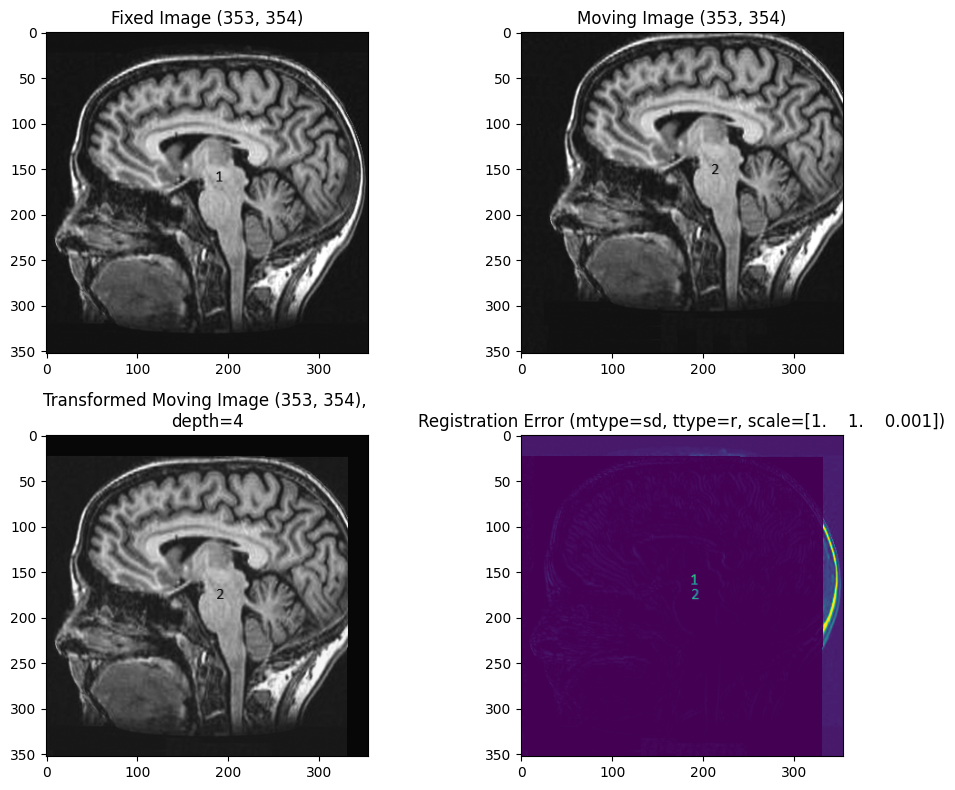


Registration took 3 sec.
22 [0.019454543282000455, 0.005702748887326625, 0.0054847100951292615, 0.005207923103103222, 0.003923416617820501, 0.003496445037074316, 0.00343864571733276, 0.003438626482978033, 0.003438625359558986, 0.0034522735069905455, 0.003379872941348036, 0.0032832835579868595, 0.003179377097764063, 0.0031791550753058353, 0.003172028698720795, 0.0031698726567341872, 0.0031698726567341855, 0.003963421621653904, 0.0039597206444410395, 0.0039584980457207705, 0.003958411053425141, 0.003958411053425141]
[0.0, 0.0, 0.000995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.002001, 0.002021, 0.003015, 0.004014, 0.002998, 0.002994, 0.002992, 0.014007, 0.015499, 0.017011, 0.014098, 0.01346]


In [8]:
start = datetime.datetime.now()
Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain2.png", "brain1.png", 'sd', 'r', tscale=[1, 1, 0.001], multi_scale_depth=4)
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')
print(len(metrics_list), metrics_list)
print(reg_time)

# Let's add some extra functionality to the framework

**TASK 1**: Add two new similarity metrics to the framework:

1.   Normalized cross-correlation (NCC)
2.   Normalized gradient correlation (NGC)

In [9]:
# The implementation has been moved above to be able to call the implemented functions in the framework
# ncc, grad, and ngc functions

In [10]:
print("Negative flag is set to be false for testing. In the framework, we return negative metric for the minimizer to work as expected.\n")

print("------------------------ NCC Testing ------------------------")
# Testing the above functions
img1 = rgb2gray(imread("brain2.png")[:,:,0:3]).astype(np.double)
img2 = rgb2gray(imread("brain1.png")[:,:,0:3]).astype(np.double)

# calc using our ncc function
result1 = ncc(img1, img1, negative=False)
result2 = ncc(img1, img2, negative=False)

print(f"Implementation \t result 1: {result1}, result 2: {result2}")

# assertion with expected results
# assert result1 == 1.0, f"Error in implementation. (Negative) NCC should equal to 1.0 as it is the same image. NCC equals {result1}"
# assert result2 != 1.0, f"Error in implementation. (Negative) NCC should not be equal to 1.0 as they are different images. NCC equals {result2}"

# comparing to opencv implementation
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)
cv_result1 = np.max(cv2.matchTemplate(img1, img1, cv2.TM_CCOEFF_NORMED))
cv_result2 = np.max(cv2.matchTemplate(img1, img2, cv2.TM_CCOEFF_NORMED))

# Print the results
print(f"OpenCV  \t result 1: {cv_result1}, result 2: {cv_result2}")


print("\n------------------------ NGC Testing ------------------------")
# Testing the above functions
img1 = rgb2gray(imread("brain1.png")[:,:,0:3]).astype(np.double)
img2 = rgb2gray(imread("brain2.png")[:,:,0:3]).astype(np.double)

ngc_result_1 = ngc(img1, img1, negative=False)
ngc_result_2 = ngc(img1, img2, negative=False)

# print(ngc_result_1.shape, type(ngc_result_1))

print("Normalized Gradient Correlation (NGC) Result on Identical Images:", ngc_result_1)
print("Normalized Gradient Correlation (NGC) Result on Different Images:", ngc_result_2)


Negative flag is set to be false for testing. In the framework, we return negative metric for the minimizer to work as expected.

------------------------ NCC Testing ------------------------
Implementation 	 result 1: 1.0, result 2: 0.4049985874003352
OpenCV  	 result 1: 1.0, result 2: 0.4049985110759735

------------------------ NGC Testing ------------------------
Normalized Gradient Correlation (NGC) Result on Identical Images: 1.0
Normalized Gradient Correlation (NGC) Result on Different Images: 0.3186412848601839


**TASK 2**: Modify the framework to be able to deal with full affine 2D transformations.
   - **QUESTION 4**: Justify how you initialize the transformation.

To make the current framework handle full affine 2D transformations, the following changes were made:
1. Move the code for creating a transformation matrix into `generate_transformation_matrix` function to avoid code duplication.
2. Initialize the number of parameters in variable `x` in `affineReg2D` function (7 parameters) by making an else if condition to handle affine transformation. The scale argument should also contain 7 values in the scaling array thus its condition was also written.
3. In `generate_transformation_matrix`, we added an if else statement for handling the affine registration. The affine transformation matrix is computed by creating a separate transformation matrix for each transformation process. For example, a transformation matrix is made for translation, rotation, scaling, and shear, each separately. The final transformation matrix `M` is obtained by performing matrix multiplication to all of them togather.

All the remaining steps were kept the same.

Parameters: [0. 0. 0. 1. 1. 0. 0.]
Parameters: [-1.29109165 -1.01469336 -0.17643849  0.79354712  0.79345227 -0.12452163
  0.12482864]
Parameters: [-2.46220033 -1.90757178 -0.17645709  0.79386276  0.79377191 -0.12466881
  0.12475292]
Parameters: [-4.80835748 -3.93124063 -0.17647223  0.79390259  0.79386585 -0.12471697
  0.12472417]


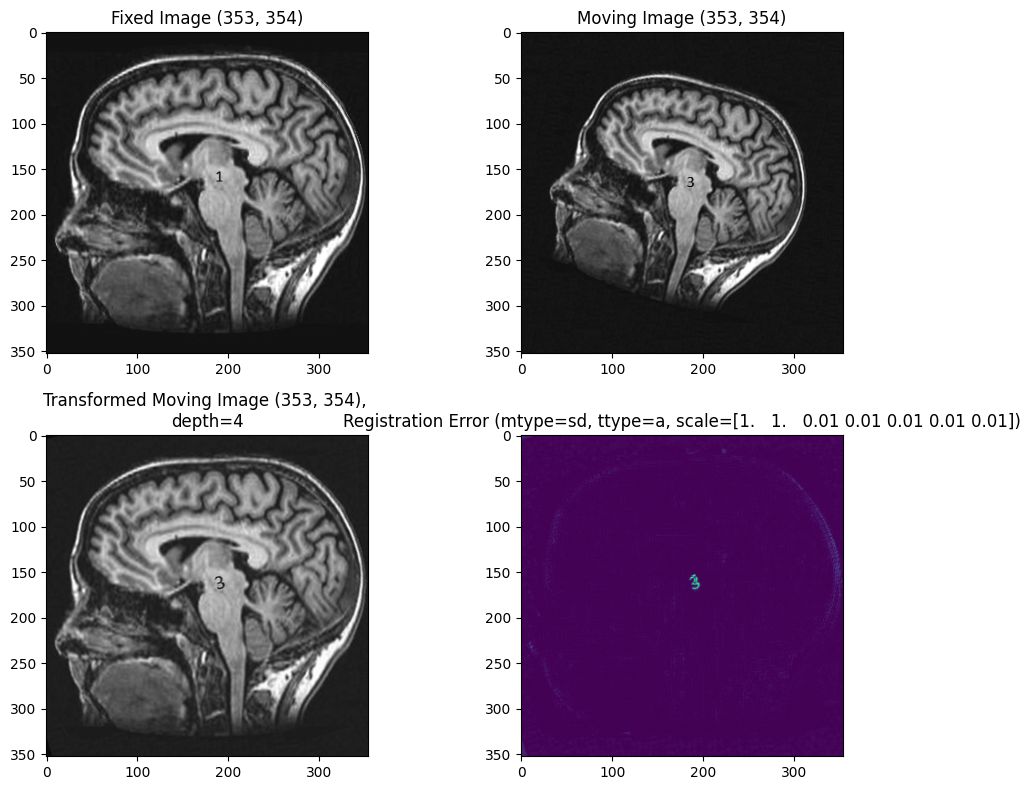


Registration took 1 sec.


In [11]:
# Running full affine 2D transformation with SD matric, depth = 4

start = datetime.datetime.now()
Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain3.png", "brain1.png", 'sd', 'a', tscale=[1, 1, 0.01, 0.01, 0.01, 0.01, 0.01], multi_scale_depth=4) # experiment different scales
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')



**TASK 3**: Implement the above modifications in a multi-resolution registration framework. The number of resolutions should be a parameter of the framework.
  - **QUESTION 5**: Discuss how each resolution is initialized.
  - **QUESTION 6**: Justify the benefits of multi-resolution in terms of computation time and/or accuracy of the final result, compared to a single resolution.

Question 5 Answer: \
We created a function called `create_multi_resolution_pyramid` to create a pyramid of images, both fixed and moving, for as many depth as indicated, starting from the lowest resolution and smallest size image, to the highest resolution (as the original images). The function retuns an array of images (one for fixed and moving), as well as the used `scaling factor` (we will explain it in question 6 answer). If the pyramid depth is indicated to be 1, the function returns a list of 1 image each, which is the original image. If the depth > 1, it applies gaussian blur followed by downsampling the image from the previous level by a factor of 2 (cutting it's width and height by 2). This is made iteratively for as many levels (depth) indicated. The final list of images is reversed to return the list starting by the lowest resolution to the highest.

The `create_multi_resolution_pyramid` is then called in `affineReg2D`, taking the fixed and moving images, as well as the indicated depth, and returning a list of images for each type. We now iterate though both lists of pyramids togather and perform 2D affine registration as usual.

Question 6 Answer: \
Thhe benifit of multi-resolution is that on every iteration, as we optimize the parameters from the lowest resolution level to the highest, we pass the optimized parameters to be the starting point for the next level registration. This way we don't start from initial parameters with 0 values, we started from the optimized ones from the previous levle. The final result is more accurate than single resolution if it required strong transformation for multiple times. Keep in mind that the optimized parameters are multiplied by the scaling factor used in the `create_multi_resolution_pyramid`, where we have to scale the translation in x and y to make it able to handle the next resolution level of higher width and height.

Text(0.5, 1.0, 'Moving Image (176, 177)')

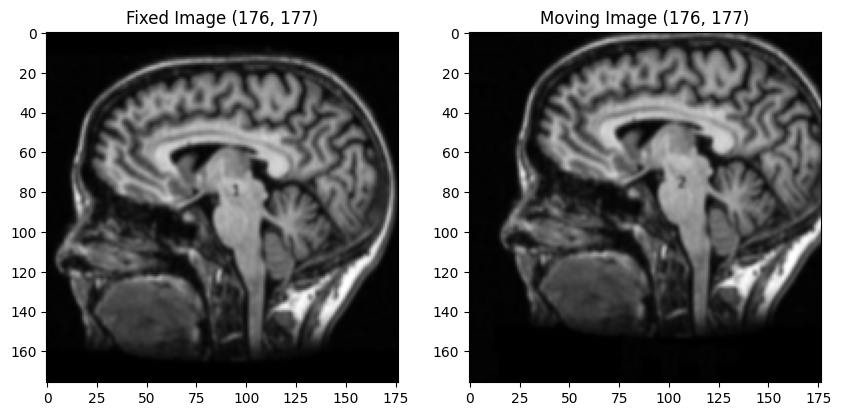

In [12]:
# TESTING THE MULTI-RESOLUTION, THE IMPLEMENTATION IS IN `create_multi_resolution_pyramid`

# Implementation for multi-resolution function that retuns a pyramid of images, both fixed and moving into 2 separate lists, and a scaling factor
# The implementation is moved to above cells for this function and used called, here is only for demonestration
Imoving = rgb2gray(imread("brain2.png")[:,:,0:3]).astype(np.double)
Ifixed = rgb2gray(imread("brain1.png")[:,:,0:3]).astype(np.double)

Imoving_list, Ifixed_list, scale_factor = create_multi_resolution_pyramid(Imoving, Ifixed, depth=4)

# Show the registration results
plt.figure(figsize=(10, 8))

view_depth_index = 2  # Only for visual debugging, no visual debugging if depth is 1 (1 level), the index must be equal to 0

plt.subplot(1, 2, 1)
plt.imshow(Ifixed_list[view_depth_index], cmap='gray')
plt.title(f'Fixed Image {Ifixed_list[view_depth_index].shape}')

plt.subplot(1, 2, 2)
plt.imshow(Imoving_list[view_depth_index], cmap='gray')
plt.title(f'Moving Image {Imoving_list[view_depth_index].shape}')

# Let's try your implementation

**TASK 4**: Show some registration results using brain1.png, brain2.png, brain3.png, and brain4.png with the different combinations of the registration framework: different <u>metrics</u>, <u>transformations</u> and <u>multi-resolution levels</u>.



Parameters: [ 2.552306   -2.880949    0.01341834]
Parameters: [ 5.49239291e+00 -5.98425131e+00  4.25732654e-04]
Parameters: [ 1.09976676e+01 -1.19971213e+01 -1.12753165e-05]
Parameters: [ 2.19978937e+01 -2.39970513e+01 -8.90964097e-06]


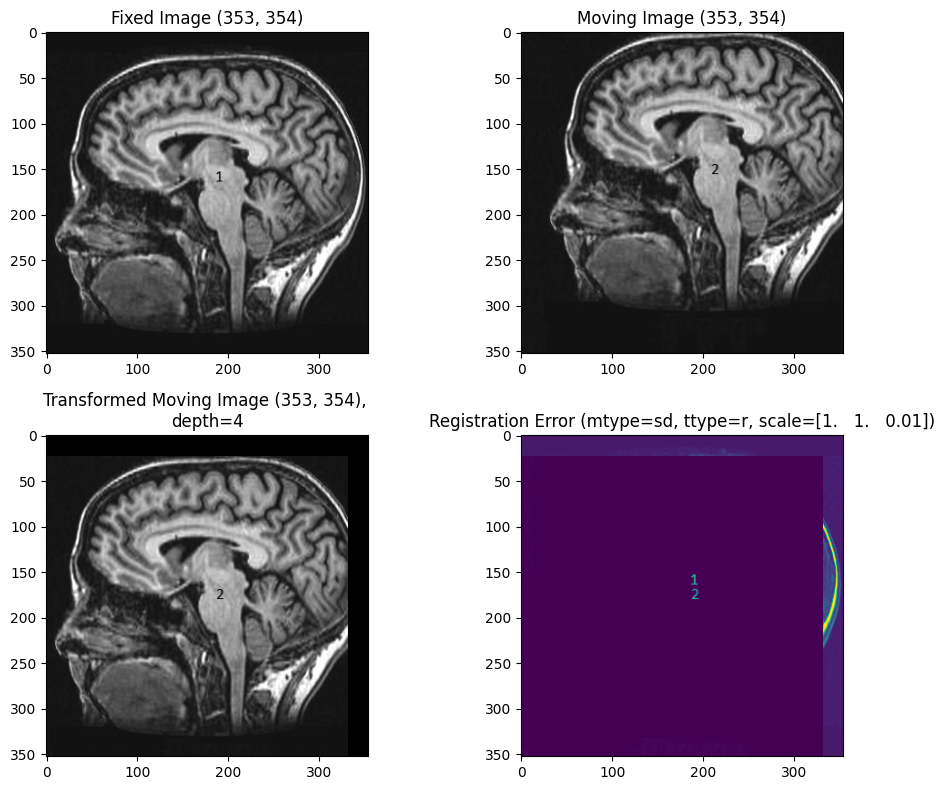


Registration took 3 sec.


In [13]:
#Your code here
# brain2,1 ngc, a, depth=4
# brain3,1 ngc, a, depth=4
# Running full affine 2D transformation with SD matric

# Metric: SD
# Registration: Rigid
# Resolutions: 4 (works on all)
# Images: brain2, brain1 

start = datetime.datetime.now()
Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain2.png", "brain1.png", 'sd', 'r', tscale=[1, 1, 0.01], multi_scale_depth=4) # experiment different scales
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

C:\Users\abdal\AppData\Local\Temp\ipykernel_19764\2857809324.py:17: RuntimeWarning: invalid value encountered in scalar divide
  result = num / denum


Parameters: [-0.7748966  -0.50545181 -0.19618631  0.79238358  0.79584381 -0.10279957
  0.10469563]
Parameters: [-1.29178264 -1.01308443 -0.19676636  0.79549518  0.79551317 -0.10399135
  0.10429056]
Parameters: [-2.4635048  -1.90646364 -0.19676062  0.79574818  0.79570021 -0.10414085
  0.10416139]
Parameters: [-4.80941623 -3.93004867 -0.19677212  0.79575927  0.7957365  -0.10415826
  0.10414691]


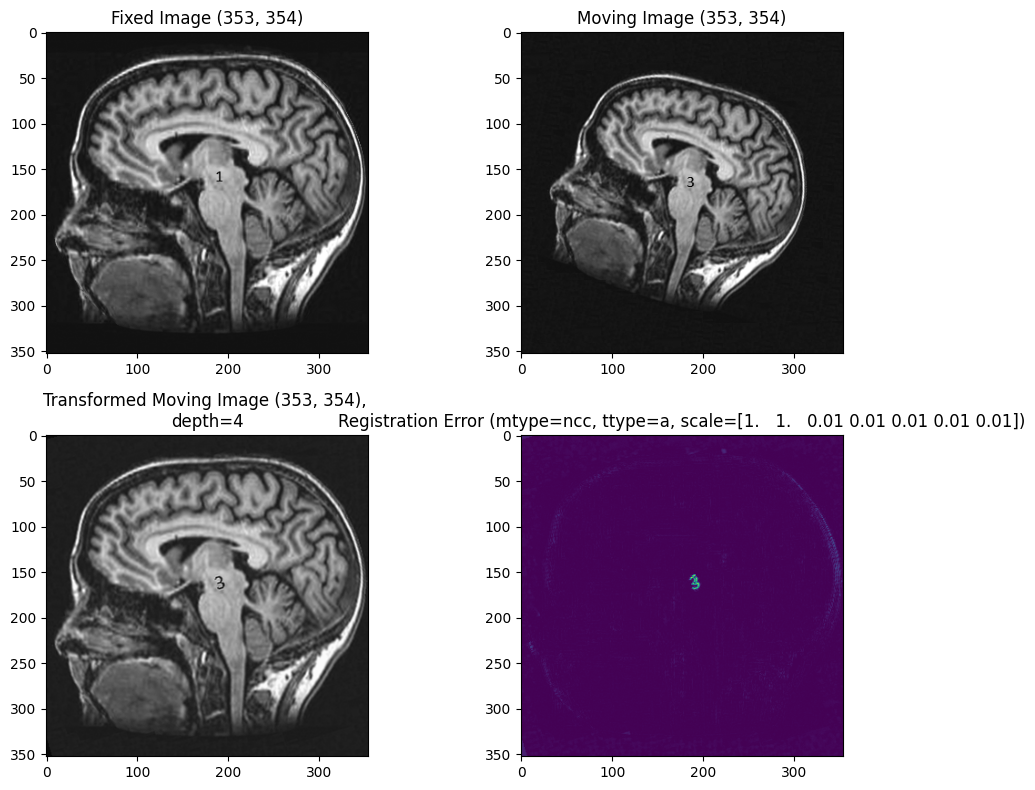

In [14]:
# Metric: NCC
# Registration: Affine
# Resolutions: 2
# Images: brain3, brain1 

start = datetime.datetime.now()
Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain3.png", "brain1.png", 'ncc', 'a', tscale=[1, 1, 0.01, 0.01, 0.01, 0.01, 0.01], multi_scale_depth=4) # experiment different scales
end = datetime.datetime.now()


Parameters: [-1.06286651 -1.14536453 -0.29822     0.80000057  0.79397112  0.00136234
  0.00160482]
Parameters: [-2.12631124e+00 -2.29023236e+00 -2.98161175e-01  8.00192790e-01
  7.94498209e-01  1.36221594e-03  1.60503452e-03]
Parameters: [-4.25284261e+00 -4.58033596e+00 -3.00529038e-01  7.98704728e-01
  7.94990757e-01  1.36239174e-03  1.60540866e-03]


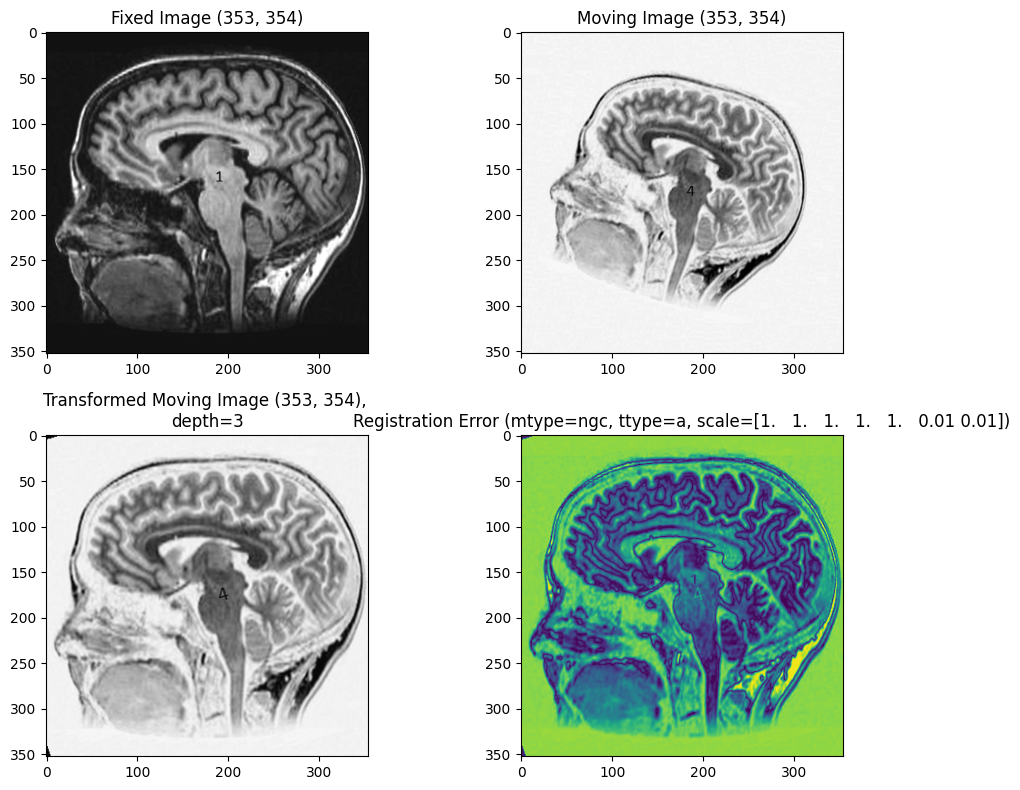


Registration took 15 sec.


In [15]:
# Metric: NGC
# Registration: Affine
# Resolutions: 4
# Images: brain4, brain1 

start = datetime.datetime.now()
Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain4.png", "brain1.png", 'ngc', 'a', tscale=[1, 1, 1, 1, 1, 0.01, 0.01], multi_scale_depth=3) # experiment different scales
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

**TASK 5**: For selected (representative) cases, plot the metric against iterations, computation time, registration results and final error (<u>propose a quantitative error measure</u>).

Parameters: [ 2.75645329e+00 -2.98343745e+00  1.50756988e-03]
Parameters: [ 5.51290557e+00 -5.96687707e+00  1.50754715e-03]
Parameters: [ 1.09520617e+01 -1.19383235e+01  1.50324665e-03]
Parameters: [ 2.19153866e+01 -2.39043731e+01  1.49911960e-03]
Parameters: [ 2.72508396e+00 -2.96725436e+00 -1.00554394e-04]
Parameters: [ 5.48730742e+00 -5.98630342e+00 -1.00568787e-04]
Parameters: [ 1.09915216e+01 -1.19900776e+01 -1.00409634e-04]
Parameters: [ 2.19842143e+01 -2.39822507e+01 -1.00282645e-04]
Parameters: [0. 0. 0.]
Parameters: [0. 0. 0.]
Parameters: [0. 0. 0.]
Parameters: [0. 0. 0.]


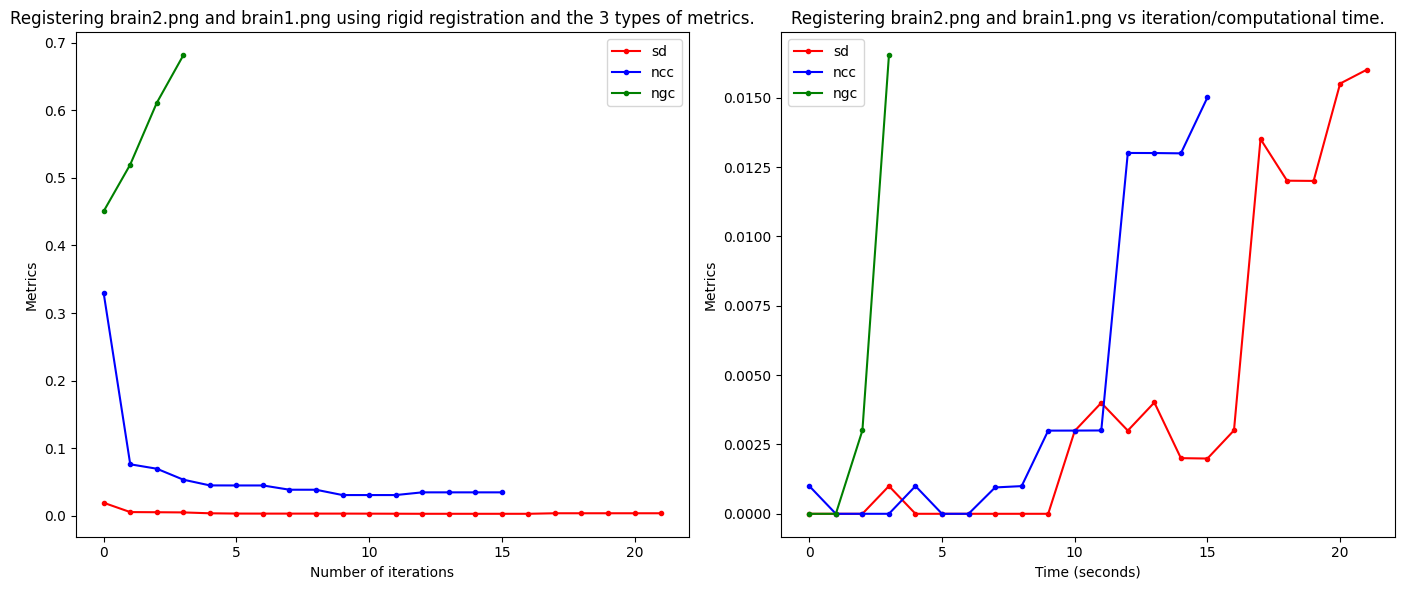

In [16]:
# Registration results for each example is displayed in the previous task with the same conclusion written in the comment below

# list of metrics and colors
e = ['sd', 'ncc', 'ngc']
colors = ['.r-', '.b-', '.g-']

# Create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Create a list to store legend labels
legend_labels = []

# Loop through the metrics and plot them in the corresponding subplot
for idx, metric in enumerate(e):
    Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain2.png", "brain1.png", e[idx], 'r', tscale=[1, 1, 0.001], multi_scale_depth=4, plot=False)
    
    # Plot the metrics in the left subplot
    axs[0].plot(np.arange(0, len(metrics_list)).tolist(), metrics_list, colors[idx])
    
    # Plot the metrics in the right subplot
    axs[1].plot(np.arange(0, len(reg_time)).tolist(), reg_time, colors[idx])
    
    # Append the legend label for this metric
    legend_labels.append(metric)

# Set labels and titles for the left subplot
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Metrics')
axs[0].set_title('Registering brain2.png and brain1.png using rigid registration and the 3 types of metrics.')
axs[0].legend(legend_labels)

# Set labels and titles for the right subplot
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Metrics')
axs[1].set_title('Registering brain2.png and brain1.png vs iteration/computational time.')
axs[1].legend(legend_labels)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Result, metric 'sd' showed the best result for brain2 and brain1 togather with a rigid registration with 4 resolutions


Parameters: [0. 0. 0. 1. 1. 0. 0.]
Parameters: [-1.29109165 -1.01469336 -0.17643849  0.79354712  0.79345227 -0.12452163
  0.12482864]
Parameters: [-2.46220033 -1.90757178 -0.17645709  0.79386276  0.79377191 -0.12466881
  0.12475292]
Parameters: [-4.80835748 -3.93124063 -0.17647223  0.79390259  0.79386585 -0.12471697
  0.12472417]


C:\Users\abdal\AppData\Local\Temp\ipykernel_19764\2857809324.py:17: RuntimeWarning: invalid value encountered in scalar divide
  result = num / denum


Parameters: [-0.7748966  -0.50545181 -0.19618631  0.79238358  0.79584381 -0.10279957
  0.10469563]
Parameters: [-1.29178264 -1.01308443 -0.19676636  0.79549518  0.79551317 -0.10399135
  0.10429056]
Parameters: [-2.4635048  -1.90646364 -0.19676062  0.79574818  0.79570021 -0.10414085
  0.10416139]
Parameters: [-4.80941623 -3.93004867 -0.19677212  0.79575927  0.7957365  -0.10415826
  0.10414691]
Parameters: [-5.02488494 -0.31399621 -0.08677252  1.03003375  0.8361832  -0.02158578
  0.05863126]
Parameters: [-9.85985865 -0.78108458 -0.11593945  1.02598813  0.84530741 -0.05163147
  0.06270067]
Parameters: [-2.46628467 -1.90434012 -0.20983806  0.79681665  0.79684206 -0.0909776
  0.09093601]
Parameters: [-4.81532979 -3.92528929 -0.20984517  0.79677446  0.79679091 -0.09096047
  0.09094431]


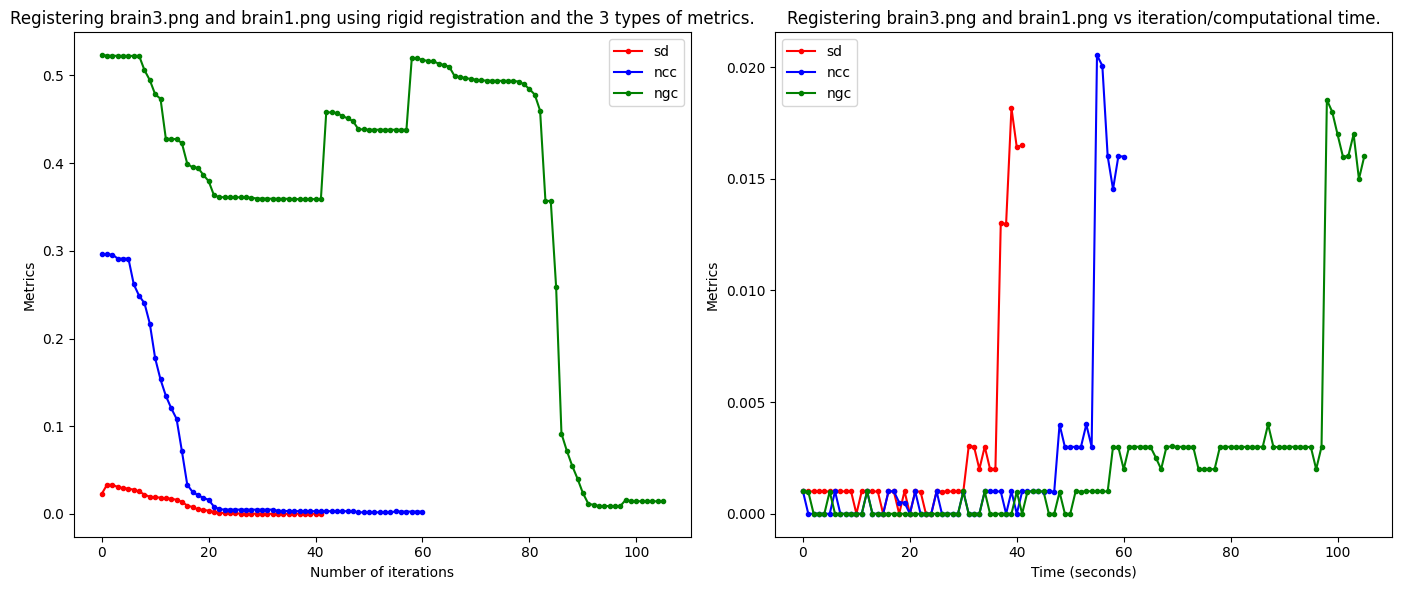

In [17]:
# Registration results for each example is displayed in the previous task with the same conclusion written in the comment below

# list of metrics and colors
e = ['sd', 'ncc', 'ngc']
colors = ['.r-', '.b-', '.g-']

# Create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Create a list to store legend labels
legend_labels = []

# Loop through the metrics and plot them in the corresponding subplot
for idx, metric in enumerate(e):
    Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain3.png", "brain1.png", e[idx], 'a', tscale=[1, 1, 0.01, 0.01, 0.01, 0.01, 0.01], multi_scale_depth=4, plot=False) 
    
    # Plot the metrics in the left subplot
    axs[0].plot(np.arange(0, len(metrics_list)).tolist(), metrics_list, colors[idx])
    
    # Plot the metrics in the right subplot
    axs[1].plot(np.arange(0, len(reg_time)).tolist(), reg_time, colors[idx])
    
    # Append the legend label for this metric
    legend_labels.append(metric)

# Set labels and titles for the left subplot
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Metrics')
axs[0].set_title('Registering brain3.png and brain1.png using rigid registration and the 3 types of metrics.')
axs[0].legend(legend_labels)

# Set labels and titles for the right subplot
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Metrics')
axs[1].set_title('Registering brain3.png and brain1.png vs iteration/computational time.')
axs[1].legend(legend_labels)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Result, metric 'ncc' showed the best result for brain3 and brain1 togather with an affine registration with 4 resolutions, 'sd' metric had also a close low results as the 'ncc' 


Parameters: [0.22823439 0.26027203 0.50372841 1.47989246 1.51921306 0.00245495
 0.00257446]
Parameters: [0.37959113 0.70014675 0.16095605 1.80499128 2.12892416 0.00223802
 0.00260442]
Parameters: [0.76031445 1.44634307 0.1360762  2.23334087 2.0370492  0.00224154
 0.00252044]
Parameters: [0.25754267 0.28321845 0.44225711 1.33300291 1.62026126 0.0027613
 0.00289554]
Parameters: [0.51508543 0.56642691 0.44248897 1.33417963 1.62052882 0.0027613
 0.00289554]
Parameters: [1.03087555 1.13093772 0.13500511 1.26921731 1.51701836 0.00278252
 0.00289818]
Parameters: [-1.06286651 -1.14536453 -0.29822     0.80000057  0.79397112  0.00136234
  0.00160482]
Parameters: [-2.12631124e+00 -2.29023236e+00 -2.98161175e-01  8.00192790e-01
  7.94498209e-01  1.36221594e-03  1.60503452e-03]
Parameters: [-4.25284261e+00 -4.58033596e+00 -3.00529038e-01  7.98704728e-01
  7.94990757e-01  1.36239174e-03  1.60540866e-03]


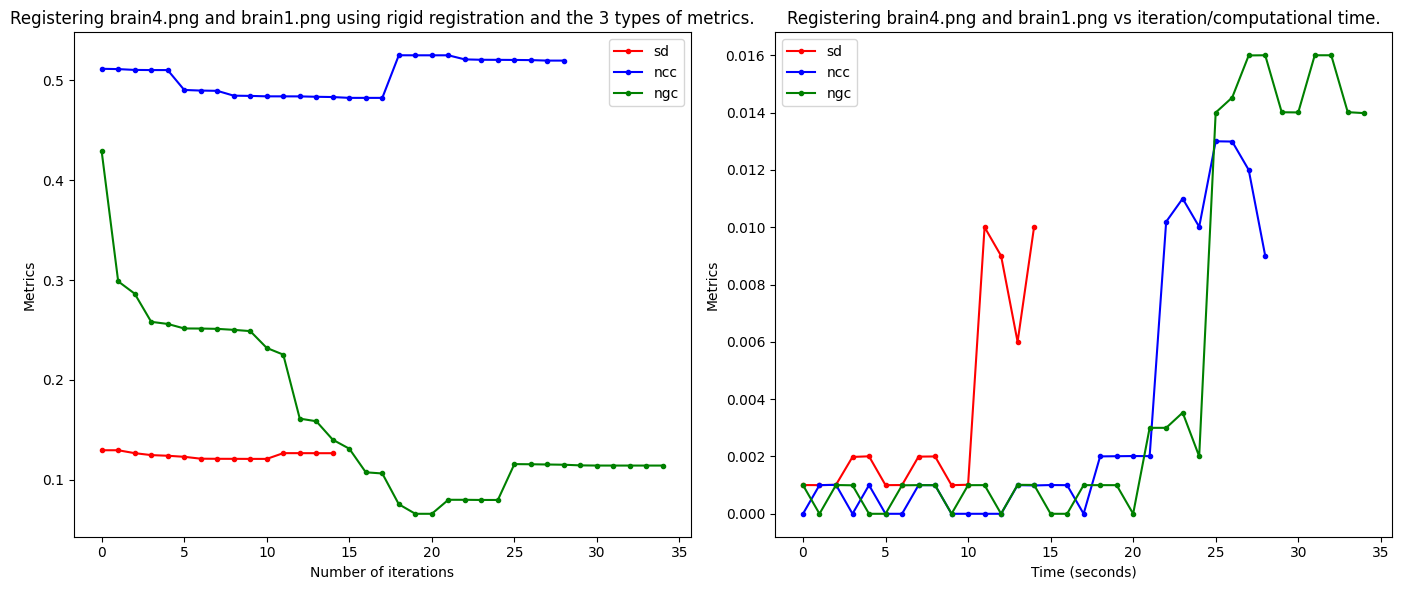

In [18]:
# Registration results for each example is displayed in the previous task with the same conclusion written in the comment below

# list of metrics and colors
e = ['sd', 'ncc', 'ngc']
colors = ['.r-', '.b-', '.g-']

# Create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Create a list to store legend labels
legend_labels = []

# Loop through the metrics and plot them in the corresponding subplot
for idx, metric in enumerate(e):
    Iregistered, transformation_matrix, metrics_list, reg_time = affineReg2D("brain4.png", "brain1.png", e[idx], 'a', tscale=[1, 1, 1, 1, 1, 0.01, 0.01], multi_scale_depth=3, plot=False) 
    
    # Plot the metrics in the left subplot
    axs[0].plot(np.arange(0, len(metrics_list)).tolist(), metrics_list, colors[idx])
    
    # Plot the metrics in the right subplot
    axs[1].plot(np.arange(0, len(reg_time)).tolist(), reg_time, colors[idx])
    
    # Append the legend label for this metric
    legend_labels.append(metric)

# Set labels and titles for the left subplot
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('Metrics')
axs[0].set_title('Registering brain4.png and brain1.png using rigid registration and the 3 types of metrics.')
axs[0].legend(legend_labels)

# Set labels and titles for the right subplot
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Metrics')
axs[1].set_title('Registering brain4.png and brain1.png vs iteration/computational time.')
axs[1].legend(legend_labels)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Result, metric 'ncc' showed the best result for brain4 and brain1 togather with an affine registration with 3 resolutions


In [49]:
# Performing quantitative error measurement

# Reading all images
Imoving_brain4 = rgb2gray(imread('brain4.png')[:,:,0:3]).astype(np.double)
Imoving_brain3 = rgb2gray(imread('brain3.png')[:,:,0:3]).astype(np.double)
Imoving_brain2 = rgb2gray(imread('brain2.png')[:,:,0:3]).astype(np.double)

Ifixed_brain1  = rgb2gray(imread('brain1.png')[:,:,0:3]).astype(np.double)

# Mutual info implementation
def mutual_information(img_fix, img_reg, num_bins=10):
    # Compute joint histogram
    joint_hist, x_edges, y_edges = np.histogram2d(
        img_fix.ravel(), img_reg.ravel(), bins=num_bins)

    # Compute marginal histograms
    hist_fix, _ = np.histogram(img_fix.ravel(), bins=num_bins)
    hist_reg, _ = np.histogram(img_reg.ravel(), bins=num_bins)

    # Normalize histograms to get probability distributions
    p_joint = joint_hist / np.sum(joint_hist)
    p_fix = hist_fix / np.sum(hist_fix)
    p_reg = hist_reg / np.sum(hist_reg)

    # Initialize mutual information
    mi = 0.0

    # Calculate mutual information using the probability distributions
    # https://lcalem.github.io/blog/2018/10/17/mutual-information#:~:text=The%20mutual%20information%20I(X,x)%20and%20p(y)
    for i in range(num_bins):
        for j in range(num_bins):
            if p_joint[i, j] > 0 and p_fix[i] > 0 and p_reg[j] > 0:
                mi += p_joint[i, j] * np.log2(p_joint[i, j] / (p_fix[i] * p_reg[j]))

    return mi


def entropy_of_difference_image(img_fix, img_reg):
    # Compute the absolute difference between the two images
    diff_image = np.abs(img_fix - img_reg)

    # Calculate the histogram of the absolute difference image
    hist, _ = np.histogram(diff_image, bins=256, range=(0, 255))

    # Normalize the histogram values to get probabilities
    prob = hist / np.sum(hist)

    # Compute the entropy using the probabilities
    entropy_value = entropy(prob, base=2)

    return entropy_value

In [43]:
Iregistered_brain2, _, _, _ = affineReg2D("brain2.png", "brain1.png", 'sd', 'r', tscale=[1, 1, 0.001], multi_scale_depth=4, plot=False)
Iregistered_brain3, _, _, _ = affineReg2D("brain3.png", "brain1.png", 'ncc', 'a', tscale=[1, 1, 0.01, 0.01, 0.01, 0.01, 0.01], multi_scale_depth=4, plot=False) 
Iregistered_brain4, _, _, _ = affineReg2D("brain4.png", "brain1.png", 'ngc', 'a', tscale=[1, 1, 1, 1, 1, 0.01, 0.01], multi_scale_depth=3, plot=False) 

Parameters: [ 2.75645329e+00 -2.98343745e+00  1.50756988e-03]
Parameters: [ 5.51290557e+00 -5.96687707e+00  1.50754715e-03]
Parameters: [ 1.09520617e+01 -1.19383235e+01  1.50324665e-03]
Parameters: [ 2.19153866e+01 -2.39043731e+01  1.49911960e-03]


C:\Users\abdal\AppData\Local\Temp\ipykernel_19764\2857809324.py:17: RuntimeWarning: invalid value encountered in scalar divide
  result = num / denum


Parameters: [-0.7748966  -0.50545181 -0.19618631  0.79238358  0.79584381 -0.10279957
  0.10469563]
Parameters: [-1.29178264 -1.01308443 -0.19676636  0.79549518  0.79551317 -0.10399135
  0.10429056]
Parameters: [-2.4635048  -1.90646364 -0.19676062  0.79574818  0.79570021 -0.10414085
  0.10416139]
Parameters: [-4.80941623 -3.93004867 -0.19677212  0.79575927  0.7957365  -0.10415826
  0.10414691]
Parameters: [-1.06286651 -1.14536453 -0.29822     0.80000057  0.79397112  0.00136234
  0.00160482]
Parameters: [-2.12631124e+00 -2.29023236e+00 -2.98161175e-01  8.00192790e-01
  7.94498209e-01  1.36221594e-03  1.60503452e-03]
Parameters: [-4.25284261e+00 -4.58033596e+00 -3.00529038e-01  7.98704728e-01
  7.94990757e-01  1.36239174e-03  1.60540866e-03]


In [50]:
print(f"Registration results of brain2 and brain1 with SD metric and depth = 4 resulted in {mutual_information(Ifixed_brain1, Iregistered_brain2)} MI and {entropy_of_difference_image(Ifixed_brain1, Iregistered_brain2)} entropy difference")
print(f"Registration results of brain3 and brain1 with NCC metric and depth = 4 resulted in {mutual_information(Ifixed_brain1, Iregistered_brain3)} MI and {entropy_of_difference_image(Ifixed_brain1, Iregistered_brain3)} entropy difference")
print(f"Registration results of brain4 and brain1 with NGC metric and depth = 3 resulted in {mutual_information(Ifixed_brain1, Iregistered_brain4)} MI and {entropy_of_difference_image(Ifixed_brain1, Iregistered_brain4)} entropy difference")

Registration results of brain2 and brain1 with SD metric and depth = 4 resulted in 2.0703733537947997 MI and 0.00536336423608191 entropy difference
Registration results of brain3 and brain1 with NCC metric and depth = 4 resulted in 2.0503767828118855 MI and 0.0 entropy difference
Registration results of brain4 and brain1 with NGC metric and depth = 3 resulted in 1.6985611117825912 MI and 0.018938553108237333 entropy difference


**QUESTION 7**: Are the results what you were expecting? If not, explain why.

Yes those are expected results for the selected representative samples and their corrosponding metrics, registration type, and amout of scaling. This is because of how the images were provided. For example, the registration of brain2 and brain1 had highest MI and low entropy (not the lowest compared to other cases), the entropy value also highlighted the part of the skull on the right that was not present in one of the images, yet the value ended up being very low.
As for brain3 and brain1, they had high MI and lowest entropy difference, as the in the registration, almost no difference can be seen (except for the labelling numbers). The registration of brain4 and brain1 was a bit challenging and still had high MI and low entropy.